In [ ]:
%env NX_CUGRAPH_AUTOCONFIG=True
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import model_selection as ms
import os
from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
def read_mmseqs_results(file):
    gao_blast_results = pd.read_table(file, 
                                  names=['query','target','fident','alnlen','mismatch',
                                              'gapopen','qstart','qend','tstart','tend',
                                              'evalue','bits','qcov','tcov'])
    return gao_blast_results

In [5]:
model_seq_info = pd.read_parquet('../data3/interim/candidate_model_seq_info.pq')
exchange_edge_df = pd.read_parquet('../data3/interim/defense_exchangable_edges.pq')


In [6]:
model_seq_info

,product_accession,seq_id,seq,name,go_process,cog_id,ss_id,defensive,assembly_stub,defense_gene,defense_cluster,functional_group
0,WP_082865576.1,000003c6658a2cf3fe4e739e0a641f624338811ec0e55e...,MFSRKRIQQTHPTPYTSVLKRAIRTLWIILDEMNLMWIPVHKSWML...,"2,3-bisphosphoglycerate-dependent phosphoglyce...",glycolytic process,None,None,False,GCF_001857945,None,None,glycolytic process
1,WP_059107350.1,0000443dc15d579934c57e4b2b1533f58a44a3040003e8...,MKPLERQLELQELQQLFSHLGALSQIERNVVECLLNDYKPREIAAQ...,sigma factor-like helix-turn-helix DNA-binding...,DNA-templated transcription initiation,None,None,False,GCF_016028295,None,None,DNA-templated transcription initiation
2,WP_162814973.1,000162b2e47bdb67d2b05159f2278de59944c6c480a622...,MSISPRAIEIHLRNVIAKLEVESRIGAVRVAVEAAL,LuxR C-terminal-related transcriptional regulator,regulation of DNA-templated transcription,None,None,False,GCF_003355455,None,None,regulation of DNA-templated transcription
3,WP_009254695.1,0001b651260c631da96f5be3bb6369d341fa33136e7272...,MTVLVIDDQIHVVEGILSEVSWENLGVDKVWKAYNAVEAKGILLLN...,helix-turn-helix domain-containing protein,regulation of transcription%2C DNA-templated,None,None,False,GCF_001717125,None,None,regulation of transcription%2C DNA-templated
4,WP_207208470.1,00027f27aeb73d6eb811d9cc411bc44441d4bc7cc86e8f...,MRDESDELNARLHRIGKHLVSLVHSGEYSTLEVAELFGVGRSTVYR...,helix-turn-helix domain-containing protein,DNA recombination,None,None,False,GCF_004137245,None,None,DNA recombination
...,...,...,...,...,...,...,...,...,...,...,...,...
200650,WP_029160896.1,f8f73a66b285c6b6e16cd1e860d948ddbc2f5a8b50fe47...,MKLKEVFGNIDTYVMCSTLNQIVNYIPIKLIEENNKAKLETIKIIN...,None,None,None,None,True,GCF_000968375,Cas__csx1_III_14,Cas__csx1_III_5,Cas__csx1_III_5
200651,WP_213348974.1,f9b8c0c1b7c511b7ea7e2fdf69d096b6a0f46d1e400514...,MTNIKNLQNLYEVNKTVRFELKPYFDEELIKPKYEGNLDENLKKFV...,None,None,None,None,True,GCF_018420025,Cas__cas12a_V-A_2,Cas__cas12f4_V-F_1,Cas__cas12f4_V-F_1
200652,WP_011695830.1,fb1c6189955983cb822473559f854aee4a880e24f6c4fd...,MESVVFYHIGVESPIAPDEPLPPLPPIPRGALVVVEGRAPIWRYGL...,None,None,None,None,True,GCF_000014945,Cas__csx3_I_III_2,Cas__csx16_III-D_1,Cas__csx16_III-D_1
200653,WP_197744982.1,fcb0308de6e0985d1bc8dd526e5792ee2da04d2cd789e6...,MFIENLNQHLNTDKKSTKDFKASLLRHSNDPISVTENETPLLLKIV...,None,None,None,None,True,GCF_902810445,Cas__cas8f_I-F_5,Cas__cas8b1_I-B_3,Cas__cas8b1_I-B_3


In [7]:
%%time
edge_df = read_mmseqs_results('../data3/interim/candidate_mmseqs_profile_out.txt')

CPU times: user 52.1 s, sys: 7.33 s, total: 59.4 s
Wall time: 1min


In [8]:
cov_cutoff = 0.8
ident_cutoff = 0.3

In [9]:
filtered_edge_df = edge_df.loc[(edge_df['qcov'] > cov_cutoff) &
                               (edge_df['fident'] > ident_cutoff) & 
                               (edge_df['query'] != edge_df['target']), :]

In [10]:
len(filtered_edge_df)

5655129

In [11]:
background_seq_ids = model_seq_info.query('~defensive')['seq_id']

In [12]:
defense_seq_ids = model_seq_info.query('defensive')['seq_id']

## Get background communities

In [13]:
background_edge_df = filtered_edge_df[filtered_edge_df['query'].isin(background_seq_ids) &
                                      filtered_edge_df['target'].isin(background_seq_ids)]

In [14]:
background_G = nx.from_pandas_edgelist(background_edge_df, 'query', 'target')
nodes = list(background_G.nodes)
missing_nodes = background_seq_ids[~background_seq_ids.isin(nodes)].to_list()
background_G.add_nodes_from(missing_nodes)

In [15]:
print(background_G)

Graph with 186032 nodes and 5348193 edges


In [16]:
%%time
background_communities = nx.community.louvain_communities(background_G, seed=7, backend='cugraph')

CPU times: user 5.34 s, sys: 551 ms, total: 5.89 s
Wall time: 16.4 s


In [17]:
cluster_list = []
for i, comp in enumerate(background_communities):
    for name in comp:
        cluster_list.append({'seq_id': name, 
                               'cluster': i})
background_cluster_df = pd.DataFrame(cluster_list)

In [18]:
background_seq_info = model_seq_info.query('~defensive').copy()
background_seq_info['short_name'] = background_seq_info['name'].str[:8]

In [19]:
nx.set_node_attributes(background_G, background_cluster_df.set_index('seq_id').to_dict(orient='index'))
nx.set_node_attributes(background_G, background_seq_info.set_index('seq_id').to_dict(orient='index'))

In [20]:
center_node_1 = '384fc4fb854f153beac5dad8a31b8febd469dffd5f5b28f04f9638ac'
neighbors_1 = nx.all_neighbors(background_G, center_node_1)
center_node_2 = '5f122c77fbe4050efaea47c69e24e03a90ec2e17fc8c787f85a15b51'
neighbors_2 = nx.all_neighbors(background_G, center_node_2)
center_node_3 = 'db5a2ffe4347dfadbd2e9995bb556c7c46aecfd92970290f2f87c952'
neighbors_3 = nx.all_neighbors(background_G, center_node_3)
neighborhood_g = nx.subgraph(background_G, [center_node_1] + list(neighbors_1) + 
                             [center_node_2] + list(neighbors_2) +
                             [center_node_3] + list(neighbors_3))

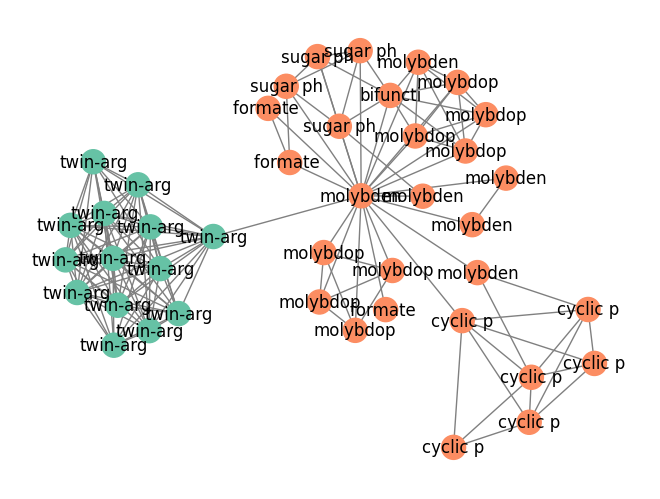

In [21]:
pos = nx.kamada_kawai_layout(neighborhood_g)
labels = nx.get_node_attributes(neighborhood_g, 'short_name')
groups = [neighborhood_g.nodes[n]['cluster'] for n in neighborhood_g.nodes]
unique_groups = list(set(groups))
color_map = dict(zip(unique_groups, plt.cm.Set2.colors[:len(unique_groups)]))
node_colors = [color_map[neighborhood_g.nodes[n]["cluster"]] for n in neighborhood_g.nodes]
nx.draw(neighborhood_g, pos, with_labels=False, node_color=node_colors, edge_color='grey')
nx.draw_networkx_labels(neighborhood_g, pos, labels=labels, font_size=12)
plt.savefig('../figures/example_cluster.svg', dpi=300, bbox_inches='tight')
plt.show()

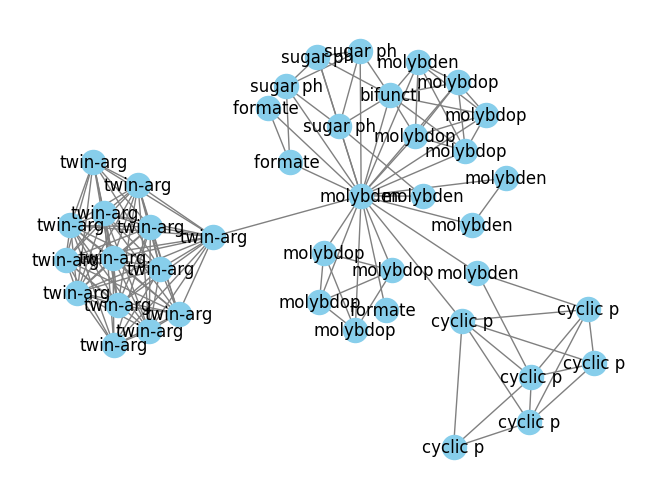

In [22]:
pos = nx.kamada_kawai_layout(neighborhood_g)
labels = nx.get_node_attributes(neighborhood_g, 'short_name')
nx.draw(neighborhood_g, pos, with_labels=False, node_color='skyblue', edge_color='grey')
nx.draw_networkx_labels(neighborhood_g, pos, labels=labels, font_size=12)
plt.savefig('../figures/example_neighborhood.svg', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
background_cluster_df['cluster'].value_counts()

cluster
4       7736
15      6217
3       5948
2       4563
10      4248
        ... 
7665       1
7666       1
7667       1
7668       1
7653       1
Name: count, Length: 18471, dtype: int64

In [24]:
background_cluster_df['cluster'] = 'b' + background_cluster_df['cluster'].astype(str)

## Get defense communities

In [25]:
defense_edge_df = filtered_edge_df[filtered_edge_df['query'].isin(defense_seq_ids) &
                                      filtered_edge_df['target'].isin(defense_seq_ids)]

In [26]:
defense_G = nx.from_pandas_edgelist(defense_edge_df, 'query', 'target')
nodes = list(defense_G.nodes)
missing_nodes = defense_seq_ids[~defense_seq_ids.isin(nodes)].to_list()
defense_G.add_nodes_from(missing_nodes)

In [27]:
print(defense_G)

Graph with 14623 nodes and 83576 edges


In [28]:
%%time
defense_communities = nx.community.louvain_communities(defense_G, seed=7, backend='cugraph')

CPU times: user 157 ms, sys: 639 μs, total: 157 ms
Wall time: 156 ms


In [29]:
cluster_list = []
for i, comp in enumerate(defense_communities):
    for name in comp:
        cluster_list.append({'seq_id': name, 
                               'cluster': i})
defense_cluster_df = pd.DataFrame(cluster_list)

In [30]:
defense_cluster_df['cluster'].value_counts()

cluster
5       659
0       455
4       452
1       427
13      282
       ... 
1598      1
1599      1
1600      1
1601      1
1592      1
Name: count, Length: 3282, dtype: int64

In [31]:
cluster_defense_edges = (defense_cluster_df
                         .merge(defense_cluster_df, how='inner', on='cluster'))

In [32]:
full_defense_edges = (pd.concat([cluster_defense_edges, 
                                 exchange_edge_df])
                      [['seq_id_x', 'seq_id_y']]
                      .query('seq_id_x != seq_id_y')
                      .drop_duplicates())

In [33]:
full_defense_G = nx.from_pandas_edgelist(full_defense_edges, 'seq_id_x', 'seq_id_y')
nodes = list(full_defense_G.nodes)
missing_nodes = defense_seq_ids[~defense_seq_ids.isin(nodes)].to_list()
full_defense_G.add_nodes_from(missing_nodes)
components = nx.connected_components(full_defense_G)
cluster_list = []
for i, comp in enumerate(components):
    for name in comp:
        cluster_list.append({'seq_id': name, 
                               'cluster': i})
full_defense_cluster_df = pd.DataFrame(cluster_list)

In [34]:
print(full_defense_G)

Graph with 14623 nodes and 2268796 edges


In [35]:
full_defense_cluster_df['cluster'].value_counts()

cluster
1      6772
106    1115
2       874
136     549
115     295
       ... 
220       1
221       1
222       1
223       1
224       1
Name: count, Length: 225, dtype: int64

In [36]:
full_defense_cluster_df['cluster'] = 'd' + full_defense_cluster_df['cluster'].astype(str)

In [37]:
%%time
full_defense_betweenness = nx.betweenness_centrality(full_defense_G, k=500, seed=7, backend='cugraph')

CPU times: user 4.32 s, sys: 388 ms, total: 4.71 s
Wall time: 5.7 s


In [38]:
full_defense_betweenness_df = (pd.DataFrame.from_dict(full_defense_betweenness, orient='index',
                                                  columns=['betweenness'])
                           .reset_index()
                           .rename(columns={'index': 'seq_id'}))

In [39]:
pd.set_option('display.max_colwidth', 100)
full_defense_betweenness_df.sort_values('betweenness', ascending=False)

,seq_id,betweenness
3358,3a3dbbdb14484bce74617009ec7b705c9d8f08a25805cf959068d730,119.865059
10725,bc0bd0570d87645134a986d247974d11cdd329cb93e54f10e84341b9,86.209473
10864,be7df80c7a1344950322db009b97849cb556bbe5d18ac61cb17fa1e9,86.209473
12215,d5f91a1328481c17771423d37bbfe49d29ff74132c158e4b171e2085,86.209473
12049,d337ed81894309eb895cfb2eb26e710031829a52c496dd999a84e74f,25.411821
...,...,...
3215,380247f5570e31c839cc82ce50955006e5a00d4a41c3c775c68bbb50,-16.948317
4418,4d6b12b7271873cf8f591750ea38b6fd24440e602b83ada0cc3b3f65,-16.948317
9285,a3dab85eca53837928f6d74b85172aca387bf345224e93f4aeba601e,-31.863379
3672,3fe5d230b7ed88207a7992b9c66680249f69d7aca3c3e625f788aeda,-223.139709


In [40]:
nx.set_node_attributes(full_defense_G, defense_cluster_df.set_index('seq_id').to_dict(orient='index'))
nx.set_node_attributes(full_defense_G, model_seq_info.set_index('seq_id').to_dict(orient='index'))

In [41]:
full_defense_G.nodes['32a6dac6ff944be6434283b463e30f11ac7bae3898a652a757045368']

{'cluster': 44,
 'product_accession': 'WP_005836895.1',
 'seq': 'MKYYLESNDLYIEIPTLVFNQIKLQAEGEYPNENGGMLAGRYSTDRHTVYIEKVVVPVEKLTGRTKFMRITKGLENVWEQLAKEGLQYVGEWHSHPNGSTQYSSTDLAAMIDIEKEVAIENPLLLIVSVRSNGLSAHNFYCYMNNQLLEYKKMIDLRDLFHGLQNQMLASLNVNREFIEHPGSKGDATEQHWIEFLRTYLPDRYKVDKAIVIDSTGNVSEQMDVVIYDAIYTPFIFKQDGFMYIPAESVYAVFEVKQDVKGYIEYAAQKVESVRTLKRTSIGMVASGKTAAARPLTKIIGGILTTTSSYSGNDTVKVQLRKLKGLQTLDLGCLCDTGSFYVDYNETEPEGIAPISSIEDNRKYIRQVYESREVKEVKFSDKDVSLFTFFLQLVNYLKFIGTVPAIDINAYLKAIHAKIDEDI',
 'name': None,
 'go_process': None,
 'cog_id': None,
 'ss_id': None,
 'defensive': True,
 'assembly_stub': 'GCF_018292165',
 'defense_gene': 'CBASS__Endonuc_small',
 'defense_cluster': 'CBASS__Endonuc_small',
 'functional_group': 'CBASS__Endonuc_small'}

In [42]:
center_node_1 = '3a3dbbdb14484bce74617009ec7b705c9d8f08a25805cf959068d730'
neighbors_1 = nx.all_neighbors(full_defense_G, center_node_1)
neighborhood_g = nx.subgraph(full_defense_G, [center_node_1] + list(neighbors_1)) 

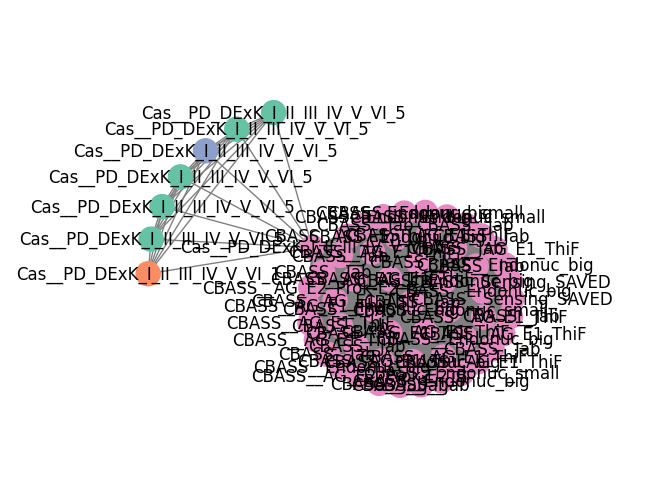

In [43]:
pos = nx.kamada_kawai_layout(neighborhood_g)
labels = nx.get_node_attributes(neighborhood_g, 'defense_gene')
groups = [neighborhood_g.nodes[n]['cluster'] for n in neighborhood_g.nodes]
unique_groups = list(set(groups))
color_map = dict(zip(unique_groups, plt.cm.Set2.colors[:len(unique_groups)]))
node_colors = [color_map[neighborhood_g.nodes[n]["cluster"]] for n in neighborhood_g.nodes]
nx.draw(neighborhood_g, pos, with_labels=False, node_color=node_colors, edge_color='grey')
nx.draw_networkx_labels(neighborhood_g, pos, labels=labels, font_size=12)
plt.axis("off")
plt.margins(0.3)

## Evaluate clusterings

In [44]:
gold_standard_edges = edge_df
gold_standard_edges = gold_standard_edges[gold_standard_edges['query'] != gold_standard_edges['target']].copy()
gold_standard_edges = (gold_standard_edges
                      .merge(model_seq_info.rename(columns={'seq_id': 'query'}), 
                             how='inner', on='query')
                      .merge(model_seq_info.rename(columns={'seq_id': 'target'}), 
                             how='inner', on='target', suffixes=('_query', '_target'))
                      .sort_values('bits', ascending=False)
                      .reset_index(drop=True))

In [45]:
cat_cluster_df = pd.concat([background_cluster_df,
                            full_defense_cluster_df])

In [46]:
assert len(cat_cluster_df) == len(model_seq_info)

In [47]:
merged_gold_standard_edges = (gold_standard_edges
                              .merge(cat_cluster_df.rename(columns={'seq_id': 'query'}), 
                                     how='inner', on='query')
                              .merge(cat_cluster_df.rename(columns={'seq_id': 'target'}), 
                                     how='inner', on='target', 
                                     suffixes=('_query', '_target')))
filtered_gold_standard_edges = merged_gold_standard_edges[
    ~(merged_gold_standard_edges['cluster_query'] == merged_gold_standard_edges['cluster_target'])]
top_gold_standard_edges = (filtered_gold_standard_edges
                           .groupby('query')
                           .head(1))
eval_df = (model_seq_info
           .merge(top_gold_standard_edges[['query', 'defensive_target']]
                  .rename(columns={'query': 'seq_id'}), 
                  how='left', on='seq_id'))
np.random.seed(7)
eval_df.loc[eval_df['defensive_target'].isna(), 'defensive_target'] = np.random.choice(
    [True, False], size=eval_df['defensive_target'].isna().sum())
eval_df['defensive_target'] = eval_df['defensive_target'].astype(bool)
f1 = f1_score(eval_df['defensive'], eval_df['defensive_target'])
f1

0.2324478921799091

## Get background defense homologs

In [48]:
control_defense_homologs = (filtered_edge_df[filtered_edge_df['query'].isin(defense_seq_ids) &
                                             filtered_edge_df['target'].isin(background_seq_ids) & 
                                             (filtered_edge_df['tcov'] > 0.8)]
                            .sort_values('bits', ascending=False)
                            .groupby('target')
                            .head(1)
                            .merge(model_seq_info, how='inner', 
                                   left_on='query', right_on='seq_id')
                            .merge(model_seq_info, 
                                   left_on='target', right_on='seq_id', 
                                   suffixes=('_query', '_target')))

In [49]:
len(control_defense_homologs)

197

In [50]:
control_defense_homologs[['name_target']].value_counts()

name_target                                                       
DNA internalization-related competence protein ComEC/Rec2             39
DNA-processing protein DprA                                           29
MarR family transcriptional regulator                                 25
group II intron reverse transcriptase/maturase                        17
trypsin-like serine protease                                          15
protein kinase                                                        12
phosphoribosyltransferase family protein                               8
patatin-like phospholipase family protein                              7
sigma-70 family RNA polymerase sigma factor                            7
TIR domain-containing protein                                          6
dNTP triphosphohydrolase                                               6
serine/threonine-protein kinase                                        3
RecQ family ATP-dependent DNA helicase                   

In [51]:
filter_background_seqs = control_defense_homologs['target']

## Split clusters

In [52]:
merged_model_seq_info = (model_seq_info[~model_seq_info['seq_id'].isin(filter_background_seqs)]
                         .merge(cat_cluster_df, how='inner', on='seq_id'))

### Split defense

In [53]:
defense_cluster_info = (merged_model_seq_info.query('defensive')
                        [['defense_cluster', 'cluster']]
                        .drop_duplicates()
                        .sample(frac=1, random_state=7)
                        .reset_index(drop=True))

In [54]:
gkf = ms.GroupKFold(n_splits=5, shuffle=False)

In [55]:
defense_cluster_fold_list = list()
for i, (train_index, test_index) in enumerate(gkf.split(defense_cluster_info, 
                                                         groups=defense_cluster_info['cluster'])):
    test_info = defense_cluster_info.loc[test_index, :].copy()
    test_info['test_fold'] = i
    defense_cluster_fold_list.append(test_info)
defense_cluster_fold_df = pd.concat(defense_cluster_fold_list)

In [56]:
merged_defense_info = (merged_model_seq_info
                       .merge(defense_cluster_fold_df, how='inner', 
                              on=['defense_cluster', 'cluster']))

In [57]:
merged_defense_info[['cluster', 'test_fold']].drop_duplicates()['cluster'].value_counts()

cluster
d1      1
d2      1
d194    1
d128    1
d178    1
       ..
d220    1
d221    1
d222    1
d223    1
d224    1
Name: count, Length: 225, dtype: int64

In [58]:
(merged_defense_info.groupby('test_fold')
 .agg(n_clusters=('cluster', 'nunique'),
      n_defense_clusters=('defense_cluster', 'nunique'),
      n_genes=('defense_gene', 'nunique'), 
      n_seqs=('seq_id', 'count')))

,n_clusters,n_defense_clusters,n_genes,n_seqs
test_fold,,,,
0,7,70,169,6918
1,51,69,114,1229
2,54,69,244,2370
3,56,69,140,1939
4,57,69,201,2167


### Split control

In [59]:
control_cluster_info = (merged_model_seq_info.query('~defensive')
                        [['functional_group', 'cluster']]
                        .drop_duplicates()
                        .sample(frac=1, random_state=7)
                        .reset_index(drop=True))

In [60]:
gkf = ms.GroupKFold(n_splits=5, shuffle=False)

In [61]:
control_cluster_fold_list = list()
for i, (train_index, test_index) in enumerate(gkf.split(control_cluster_info, 
                                                         groups=control_cluster_info['cluster'])):
    test_info = control_cluster_info.loc[test_index, :].copy()
    test_info['test_fold'] = i
    control_cluster_fold_list.append(test_info)
control_cluster_fold_df = pd.concat(control_cluster_fold_list)

In [62]:
merged_control_info = (merged_model_seq_info
                       .merge(control_cluster_fold_df, how='inner', 
                              on=['functional_group', 'cluster']))

In [63]:
merged_control_info[['cluster', 'test_fold']].drop_duplicates()['cluster'].value_counts()

cluster
b18470    1
b40       1
b18431    1
b18432    1
b18433    1
         ..
b2264     1
b52       1
b0        1
b10       1
b69       1
Name: count, Length: 18466, dtype: int64

In [64]:
(merged_control_info.groupby('test_fold')
 .agg(n_clusters=('cluster', 'nunique'),
      n_fun_groups=('functional_group', 'nunique'),
      n_seqs=('seq_id', 'count')))

,n_clusters,n_fun_groups,n_seqs
test_fold,,,
0,3693,621,37088
1,3694,593,44722
2,3693,580,35086
3,3693,588,37011
4,3693,605,31928


In [65]:
cat_info = pd.concat([merged_defense_info, 
                      merged_control_info])

In [66]:
agg_model_seq_info = (cat_info.groupby('test_fold')
                      .agg(n_seqs=('seq_id', 'count'), 
                           frac_defensive=('defensive', 'mean'), 
                           n_exchangable=('defense_cluster', 'nunique'), 
                           n_clusters=('cluster', 'nunique'), 
                           n_functional_groups=('functional_group', 'nunique')))

In [67]:
agg_model_seq_info

,n_seqs,frac_defensive,n_exchangable,n_clusters,n_functional_groups
test_fold,,,,,
0,44006,0.157206,70,3700,691
1,45951,0.026746,69,3745,662
2,37456,0.063274,69,3747,649
3,38950,0.049782,69,3749,657
4,34095,0.063558,69,3750,674


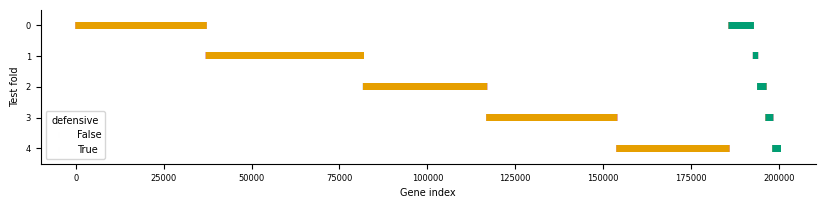

In [68]:
plt.subplots(figsize=(10,2))
sns.stripplot(data=cat_info.sort_values(['defensive', 'test_fold']).reset_index(drop=True).reset_index(), hue='defensive', x='index', y='test_fold', 
                palette=sns.color_palette(['#e69f00', '#009e73']), marker="|", linewidth=0.005, orient='h', jitter=False, rasterized=True)
sns.despine()
plt.ylabel('Test fold')
plt.xlabel('Gene index')
plt.savefig('../figures/cv_split.svg', dpi=300, bbox_inches='tight')

In [69]:
fun_info = (cat_info[['defensive', 'test_fold', 'functional_group']].drop_duplicates()
            .sort_values(['defensive', 'test_fold'])
            .reset_index(drop=True)
            .reset_index())

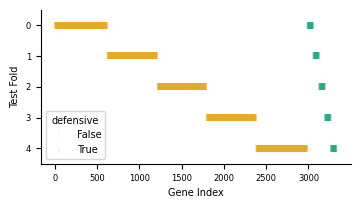

In [70]:
plt.subplots(figsize=(4,2))
sns.stripplot(data=fun_info, hue='defensive', x='index', y='test_fold', 
                palette=sns.color_palette(['#e69f00', '#009e73']), marker="|", linewidth=0.1, orient='h', jitter=False, 
              rasterized=True)
sns.despine()
plt.ylabel('Test Fold')
plt.xlabel('Gene Index')
plt.savefig('../figures/cv_split_fun_group.svg', dpi=300, bbox_inches='tight')

In [195]:
ft_dir = '../data/genome_downloads/ft/'
ft_file_dict = {x.split('.')[0]: x for x in os.listdir(ft_dir) if '.txt' in x}

In [196]:
def select_genes(assembly, assembly_df, ft_file_dict=ft_file_dict):
    assembly_ft_file = ft_file_dict[assembly]
    assembly_ft = pd.read_table(os.path.join(ft_dir, assembly_ft_file))
    relevant_ft = (assembly_ft[assembly_ft['product_accession']
                               .isin(assembly_df['product_accession'])]
                   .groupby('product_accession')
                   .sample(n=1, random_state=7))
    relevant_ft['protein_context_id'] = (relevant_ft['product_accession'] + '|' +
                                         relevant_ft['genomic_accession'] + '|' +
                                         relevant_ft['start'].astype(str) + '|' +
                                         relevant_ft['strand']) 
    relevant_ft = relevant_ft[['protein_context_id', 'product_accession', 
                               'genomic_accession', 'start', 'strand']]
    return relevant_ft
    
    

In [197]:
len(cat_info)

200458

In [198]:
ft_list = Parallel(n_jobs=40)(delayed(select_genes)(assembly, assembly_df)
                              for assembly, assembly_df in tqdm(cat_info.groupby('assembly_stub'), 
                                                                total=cat_info['assembly_stub'].nunique(), 
                                                                position=0))

100%|██████████| 17109/17109 [02:13<00:00, 128.01it/s]


In [199]:
select_gene_df = pd.concat(ft_list)

In [200]:
len(select_gene_df)

200458

In [202]:
gene_merged_info = (cat_info.merge(select_gene_df, how='inner', on='product_accession'))

In [167]:
with open('../data3/interim/model_seqs.faa', 'w') as f:
    for _, row in tqdm(gene_merged_info.iterrows(), total=len(gene_merged_info), position=0):
        print('>' + row['seq_id'], file=f)
        seq = row['seq']
        if 'X' in seq:
            seq = seq.replace('X', '')
        if 'U' in seq:
            seq = seq.replace('U', 'C')
        if 'B' in seq:
            seq = seq.replace('B', 'N')
        if 'J' in seq:
            seq = seq.replace('J', 'L')
        print(seq, file=f)


100%|██████████| 200458/200458 [00:07<00:00, 28613.82it/s]


In [203]:
for test_fold, test_fold_df in gene_merged_info.groupby('test_fold'):
    with open('../data3/interim/model_split_' + str(test_fold) + '_test_seqs.faa', 'w') as f:
        for _, row in tqdm(test_fold_df.iterrows(), total=len(test_fold_df), position=0):
            print('>' + row['seq_id'], file=f)
            print(row['seq'], file=f)

100%|██████████| 34095/34095 [00:01<00:00, 27437.55it/s]


In [6]:
with open('../data3/interim/positive_model_seqs.faa', 'w') as f:
    for _, row in tqdm(gene_merged_info.query('defensive').iterrows(), position=0):
        print('>' + row['seq_id'], file=f)
        seq = row['seq']
        if 'X' in seq:
            seq = seq.replace('X', '')
        if 'U' in seq:
            seq = seq.replace('U', 'C')
        if 'B' in seq:
            seq = seq.replace('B', 'N')
        if 'J' in seq:
            seq = seq.replace('J', 'L')
        print(seq, file=f)

14623it [00:00, 27967.60it/s]


In [204]:
gene_merged_info.to_parquet('../data3/interim/model_seq_info.pq')

In [5]:
import pandas as pd

In [3]:
def read_mmseqs_results(file):
    gao_blast_results = pd.read_table(file, 
                                  names=['query','target','fident','alnlen','mismatch',
                                              'gapopen','qstart','qend','tstart','tend',
                                              'evalue','bits','qcov','tcov'])
    return gao_blast_results

In [4]:
model_seq_info = pd.read_parquet('../data3/interim/model_seq_info.pq')

In [5]:
clusters = pd.read_parquet('../data3/interim/refseq_cover_clusters.pq')

In [6]:
%%time
edge_df = read_mmseqs_results('../data3/interim/candidate_mmseqs_profile_out.txt')

CPU times: user 1min, sys: 7.77 s, total: 1min 7s
Wall time: 1min 8s


In [13]:
twin_arg_info = (model_seq_info[model_seq_info['name'].str.contains('arginine translocase', na=False)]
                 .merge(clusters, how='inner', on='seq_id'))

In [14]:
twin_arg_info['cluster_id'].value_counts()

cluster_id
ffe63589a401115d98a2710a91b8c3762333bdf251e4aea1aab66992    1
00a95b55510486df3b38960057cedee5c1b5f427d9865a552d332d8e    1
015f79b3281237be11ab4809d1fe954cb830795899457534aba12cd5    1
01650db69c5db7eff93a2f6227e6ed74f3a12eb770367d6fe9782167    1
0327a73c6abee0fc98d915677712ce2aa6b851b5cc92cb45d0e2ee1c    1
                                                           ..
0a19f1413c0ad3651a2e0cd548e6a8c83d15a7db80b90fae238e63ab    1
0ac0f7f0c86dd2b7a3efb5b0937fa9d1b0e21be46b3172a7aab86b00    1
0df8adec1ff3e8ea276e7346455461208080a118740c905d3384e69f    1
0e331d35c41183ce7835a80e5945af736319788ba919e322495f08a3    1
0e91db015531b7c091f822b7e7a430d1a50aed964d7eb7cbeaaaa38c    1
Name: count, Length: 433, dtype: int64

In [15]:
twin_arg_edge_df = edge_df[edge_df['query'].isin(twin_arg_info['seq_id']) & 
                           edge_df['target'].isin(twin_arg_info['seq_id'])]

In [22]:
filtered_twin_arg_edge_df = (twin_arg_edge_df[(twin_arg_edge_df['query'] != twin_arg_edge_df['target']) & 
                                              (twin_arg_edge_df['fident'] > 0.3) & 
                                              ((twin_arg_edge_df['qcov'] > 0.8) |
                                               (twin_arg_edge_df['tcov'] > 0.8))]
                             .reset_index(drop=True))

In [24]:
pd.set_option('display.max_colwidth', 100)
filtered_twin_arg_edge_df.sort_values('evalue')

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov
9767,04548ed3ece842d373dfab8c02074c2dd6d35ef856dfefc193d1ac21,a5fbfb9e29ed8edfbab77ed8d3bcf17abdb9c9fc4d45ccac5a6f11cd,0.706,384,108,0,1,384,1,369,4.771000e-171,546,0.716,0.889
1068,a5fbfb9e29ed8edfbab77ed8d3bcf17abdb9c9fc4d45ccac5a6f11cd,04548ed3ece842d373dfab8c02074c2dd6d35ef856dfefc193d1ac21,0.684,379,115,0,1,364,1,379,5.584000e-164,519,0.877,0.707
8376,9777eaa6435812eeac8ca09357031a454cfaa24df34bf56dd55ca81b,7bb5deeee730f671732a73869a7251499ee1e7a15f5deb97f7a27434,0.623,346,130,0,1,346,1,346,7.876000e-129,423,0.641,0.856
5784,7bb5deeee730f671732a73869a7251499ee1e7a15f5deb97f7a27434,9777eaa6435812eeac8ca09357031a454cfaa24df34bf56dd55ca81b,0.636,325,118,0,1,324,1,325,7.682000e-126,408,0.802,0.602
11672,ee1f72d03878e752f47c2343e055d54a969546187deae33aacfbfbbe,a5fbfb9e29ed8edfbab77ed8d3bcf17abdb9c9fc4d45ccac5a6f11cd,0.576,347,145,0,17,359,16,362,7.495000e-119,386,0.932,0.836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8434,d2a3b34b891f5c8ca8b20233044139653c4908ceb13c3352bc4fd5fa,74d222dd770e05eb0cea18efb477db88a9ce437e373dd73265c61083,0.637,26,8,0,1,26,1,24,8.191000e-04,36,0.867,0.286
8436,d2a3b34b891f5c8ca8b20233044139653c4908ceb13c3352bc4fd5fa,8733951731d358f5213a5ed41146447f470efc996fb479d9f4fbbd28,0.637,26,9,0,3,28,2,27,8.191000e-04,36,0.867,0.283
8435,d2a3b34b891f5c8ca8b20233044139653c4908ceb13c3352bc4fd5fa,503061abafe075e696acaf1180b505fa0967670eeeecadcae68f2879,0.581,29,11,0,1,29,1,27,8.191000e-04,36,0.967,0.303
8433,d2a3b34b891f5c8ca8b20233044139653c4908ceb13c3352bc4fd5fa,940be29ad4424c20284faed0106664bd9e4ef177320a3f308638ffb2,0.637,26,9,0,5,30,3,28,8.191000e-04,36,0.867,0.342


In [25]:
filtered_twin_arg_edge_df[(filtered_twin_arg_edge_df['qcov'] > 0.8) & 
                          (filtered_twin_arg_edge_df['tcov'] > 0.8)]

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov
45,a4d02fd3af2fd3fbbd0ee2b5bce3d9c78cf8e51975a239b07496285d,a7ccb04656f757f9c35cf7dba6988226b5c4463fd5d84a9c711989cd,0.698,52,15,0,4,55,3,54,4.669000e-17,76,0.825,0.881
56,a4d02fd3af2fd3fbbd0ee2b5bce3d9c78cf8e51975a239b07496285d,8ff4a94996b720adb15e29ff235245808fb6e585a84b10f9044a2a7f,0.531,66,28,0,1,61,1,66,7.575000e-15,69,0.968,0.857
58,a4d02fd3af2fd3fbbd0ee2b5bce3d9c78cf8e51975a239b07496285d,7939d869cc0047eb27dd90e7ba8094c2e7f513fc7da0dc5d5bcd6cb0,0.581,58,24,0,3,60,2,59,1.968000e-14,68,0.921,0.921
61,a4d02fd3af2fd3fbbd0ee2b5bce3d9c78cf8e51975a239b07496285d,3f9aa1305e673e4fa99c6ba5ec4eb9e6da715321cb2318f28b136bf6,0.578,58,24,0,1,58,1,58,2.705000e-14,68,0.921,0.866
77,a4d02fd3af2fd3fbbd0ee2b5bce3d9c78cf8e51975a239b07496285d,985dd02a213c0f29a80bdc9644ee9220361840910e55ff27540e3047,0.575,52,21,0,3,54,2,52,8.345000e-12,61,0.825,0.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12022,5044952251b844cf7b9d8470db2ac0ebb59a502ecd110f0961cf1b09,a2be69ea4102325657667ef71ad0ed87d80ba49bd04e56c816e49fd6,0.426,229,129,0,1,226,1,229,7.100000e-48,174,0.904,0.895
12025,5044952251b844cf7b9d8470db2ac0ebb59a502ecd110f0961cf1b09,fdc41f371780f7a392488b4d6f50695754cd506fe8c083eab96a97bd,0.411,230,134,0,1,230,9,236,2.711000e-45,167,0.920,0.966
12056,4d8c59ad80163f1571035bb0d7ba40895b333851472020698c6fc23a,71a2672d5cb3e96194063bc7434d22f4f9f966a3bc099895c5624a91,0.379,309,137,0,1,221,1,309,4.493000e-57,199,0.995,1.000
12083,d412f41252388e921d1f410c55f75eacf0068b74b2e313005f20f9f8,503061abafe075e696acaf1180b505fa0967670eeeecadcae68f2879,0.413,75,41,0,1,71,1,75,1.717000e-10,57,0.973,0.843


In [21]:
'a8a87e8ddf03a0f7ecaa9c35c207b7d9db5de71d8bbe0667e4f9343e' == 'a8a87e8ddf03a0f7ecaa9c35c207b7d9db5de71d8bbe0667e4f9343e'

True